In [1]:
import numpy as np
import torch
from torch.utils import data
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib import image
from matplotlib import patches
import zipfile
from pycocotools.coco import COCO
import pandas as pd
import cv2
import random as rn
%matplotlib inline

In [2]:
# Download Dataset (Uncomment to download)
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# !mkdir data
# !mv *.zip data/

# Unzip data
# with zipfile.ZipFile('data/train2017.zip', 'r') as zip_ref: zip_ref.extractall('data/')
# with zipfile.ZipFile('data/val2017.zip', 'r') as zip_ref: zip_ref.extractall('data/')
# with zipfile.ZipFile('data/annotations_trainval2017.zip', 'r') as zip_ref: zip_ref.extractall('data/')

In [3]:
# Load annotations for training data
train_annot_path = 'data/annotations/person_keypoints_train2017.json'
val_annot_path = 'data/annotations/person_keypoints_val2017.json'
train_coco = COCO(train_annot_path) # load annotations for training set
val_coco = COCO(val_annot_path) # load annotations for validation set

loading annotations into memory...
Done (t=6.52s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [4]:
# Load meta data on images: https://towardsdatascience.com/how-to-analyze-the-coco-dataset-for-pose-estimation-7296e2ffb12e
def get_meta(coco):
    ids = list(coco.imgs.keys())
    for i, img_id in enumerate(ids):
        img_meta = coco.imgs[img_id]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # basic parameters of an image
        img_file_name = img_meta['file_name']
        w = img_meta['width']
        h = img_meta['height']
        # retrieve metadata for all persons in the current image
        anns = coco.loadAnns(ann_ids)

        yield [img_id, img_file_name, w, h, anns]
        
def convert_to_df(coco):
    images_data = []
    persons_data = []
    # iterate over all images
    for img_id, img_fname, w, h, meta in get_meta(coco):
        images_data.append({
            'image_id': int(img_id),
            'path': img_fname,
            'width': int(w),
            'height': int(h)
        })
        # iterate over all metadata
        for m in meta:
            persons_data.append({
                'image_id': m['image_id'],
                'is_crowd': m['iscrowd'],
                'bbox': m['bbox'],
                'area': m['area'],
                'num_keypoints': m['num_keypoints'],
                'keypoints': m['keypoints'],
            })
    # create dataframe with image paths
    images_df = pd.DataFrame(images_data)
    images_df.set_index('image_id', inplace=True)
    # create dataframe with persons
    persons_df = pd.DataFrame(persons_data)
    persons_df.set_index('image_id', inplace=True)
    return images_df, persons_df

# Create train and validation dfs
images_df, persons_df = convert_to_df(train_coco)
train_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)

images_df, persons_df = convert_to_df(val_coco)
val_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)

In [5]:
val_coco_df

,path,width,height,is_crowd,bbox,area,num_keypoints,keypoints
image_id,,,,,,,,
139,000000000139.jpg,640,426,0,"[412.8, 157.61, 53.05, 138.01]",2913.11040,15,"[427, 170, 1, 429, 169, 2, 0, 0, 0, 434, 168, ..."
139,000000000139.jpg,640,426,0,"[384.43, 172.21, 15.12, 35.74]",435.14495,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
785,000000000785.jpg,640,425,0,"[280.79, 44.73, 218.7, 346.68]",27789.11055,17,"[367, 81, 2, 374, 73, 2, 360, 75, 2, 386, 78, ..."
872,000000000872.jpg,621,640,0,"[145.26, 100.67, 291.95, 457.35]",25759.04240,12,"[367, 138, 2, 0, 0, 0, 360, 134, 2, 0, 0, 0, 3..."
872,000000000872.jpg,621,640,0,"[163.73, 126.42, 265.69, 480.4]",48091.75195,15,"[211, 187, 1, 215, 179, 2, 0, 0, 0, 241, 175, ..."
...,...,...,...,...,...,...,...,...
581357,000000581357.jpg,612,612,0,"[180.89, 440.51, 21.1, 38.36]",371.49395,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
581357,000000581357.jpg,612,612,0,"[249.22, 419.65, 13.2, 24.53]",169.55635,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
581357,000000581357.jpg,612,612,0,"[211.18, 420.26, 23.38, 40.03]",542.16740,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
# Drop all photos with no keypoints or where a group is just marked as crowd
train_coco_df = train_coco_df[train_coco_df['is_crowd']==0]
train_coco_df = train_coco_df[train_coco_df['num_keypoints']>0]

val_coco_df = val_coco_df[val_coco_df['is_crowd']==0]
val_coco_df = val_coco_df[val_coco_df['num_keypoints']>0]

In [7]:
# Takes in a dataframe and index and outputs a figure of it with keypoints at default dimensions
def displayImageFromDf(coco_df, index):
    img = image.imread(f'data/train2017/{coco_df.iloc[index]["path"]}')
    bbox = coco_df.iloc[index]["bbox"]
    keypoints = coco_df.iloc[index]["keypoints"]

    fig, ax = plt.subplots()
    ax.imshow(img)

    # Show kps
    for i in range(2, len(keypoints), 3):
        ax.plot(keypoints[i-2], keypoints[i-1], marker='x', color="red")

    # Show bbox
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

In [8]:
# Takes in a dataframe and index and outputs a figure of it cropped to 224x224 with keypoints moved
def displayCroppedImageFromDf(coco_df, index):
    img = image.imread(f'data/train2017/{coco_df.iloc[index]["path"]}')
    bbox = np.array(coco_df.iloc[index]["bbox"]).astype(np.int64)
    keypoints = coco_df.iloc[index]["keypoints"]
    
    # Crop image
    img = img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    
    x_scale = 224/img.shape[1]
    y_scale = 224/img.shape[0]
    
    # Scale image
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Show kps
    for i in range(2, len(keypoints), 3):
        x = (keypoints[i-2] - bbox[0]) * x_scale * 1/224
        y = (keypoints[i-1] - bbox[1]) * y_scale * 1/224
        if x < 0: x = 0
        if y < 0: y = 0
            
        ax.plot(x*224, y*224, marker='x', color="red")

    plt.show()

In [9]:
# Takes in a CXHXW image with keypoints and displays it with keypoints
def displayImageWithKeyPoints(img, keypoints, ax=None, show=True):
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)

    #fig = None
    if(ax is None):
        fig, ax = plt.subplots()
    ax.imshow(img)
    w = img.shape[1]
    h = img.shape[0]
    
    # Show kps
    
    for i in range(1, len(keypoints), 2):
        x = keypoints[i-1]
        y = keypoints[i]
        x = (x)*w + w/2
        y = (y)*h + h/2
        if x < 0 or y < 0: continue
        ax.plot(x, y, marker='x', color="red")
    if(show):
        plt.show()

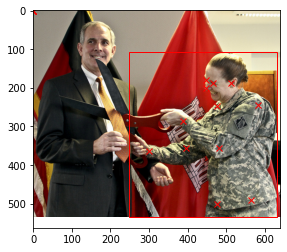

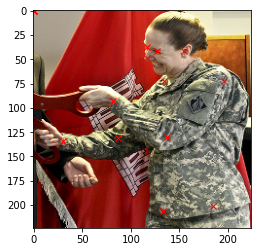

In [10]:
displayImageFromDf(train_coco_df, 21)
displayCroppedImageFromDf(train_coco_df, 21)

In [11]:
# normalizing transform defined in the DeepPose paper
# y is a 2 vec, b is a 4 vec of bcx, bcy, bw, bh
def N(y, b):
    return [ (y[0]-b[0]) * 1/b[2], (y[1]-b[1]) * 1/b[3]]

def Ninv(y, b):
    return []

In [12]:
# Create datasets for training and validation
class Coco(Dataset):
    def __init__(self, df, source, dimensions, transform=None):
        super().__init__()
        # Dataframe of annotations
        self.df = df
        # Either train or val to indicate set
        self.source = source
        # Square dimensions of image
        self.dimensions = dimensions
        # transform
        self.transform = transform

    def __getitem__(self, index):
        # Get data
        img = image.imread(f'data/{self.source}2017/{self.df.iloc[index]["path"]}')
        bbox = np.array(self.df.iloc[index]["bbox"]).astype(np.int64)
        keypoints = self.df.iloc[index]["keypoints"]
        
        # Account for potential gray images by adding channels
        if len(img.shape) == 2 or img.shape[2] == 1:
            if (len(img.shape) == 2): img = np.expand_dims(img,-1)
            img = cv2.merge([img,img,img])
        
        # Crop image to bbox
        img = img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
        
        # Scale image 
        img = cv2.resize(img, dsize=(self.dimensions, self.dimensions), interpolation=cv2.INTER_CUBIC)

        bbox_tl_x = bbox[0]
        bbox_tl_y = bbox[1]
        w_original = bbox[2]
        h_original = bbox[3]

        bbox_rescale = [self.dimensions/2, self.dimensions/2, self.dimensions, self.dimensions]
        
        # Move keypoints to new bbox locations accounting for crop, scale, and normalization
        final_keypoints = []
        for i in range(2, len(keypoints), 3):
            x = (keypoints[i-2] - bbox_tl_x) * self.dimensions / w_original
            y = (keypoints[i-1] - bbox_tl_y)* self.dimensions / h_original

            x, y = N([x, y], bbox_rescale)

            v = keypoints[i]
            #print(str(x) + " " + str(y))
            
            # If resizing put keypoint outside of image then remove it
            if x < -0.5 or y < -0.5 or x > 0.5 or y > 0.5: v = 0
            
            # Set keypoints to -1 if not visible
            if v == 0:
                x = -1
                y = -1
                
            # Add final keypoints to final_keypoints
            final_keypoints.extend([x,y])
            
        img = img.astype('uint8') # enforce int 
        if self.transform: img = self.transform(img)
            
        return img, torch.FloatTensor(final_keypoints)

    def __len__(self):
        return len(self.df)

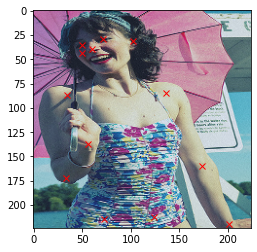

In [13]:
# Data loader
composed_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
train_dataloader = DataLoader(
    dataset=Coco(train_coco_df, 'train', 224, transform=composed_transforms),
    batch_size=1, shuffle=False, num_workers=0
)

# Example from data loader after normalization
img, labels = iter(train_dataloader).next()
a = img[0].numpy()
b = (a - np.min(a))/np.ptp(a)
displayImageWithKeyPoints(b, labels[0])

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("No GPU")

Using the GPU!


In [63]:
# Initialize network
model = models.resnet18(pretrained=True)

# Freeze params
for param in model.parameters():
    param.requires_grad = False

# Replace FC
model.fc = torch.nn.Linear(512, 34)
#model = torch.nn.Sequential(model, torch.nn.Linear(4096,34))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
# Initialize network
model = models.resnet18(pretrained=True)#models.mobilenet_v2(pretrained=True)

# Freeze params
'''
for param in model.parameters():
    param.requires_grad = False
'''

# Replace FC
#model.classifier = torch.nn.Sequential(
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=False), 
    torch.nn.Linear(512, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 34),
    torch.nn.Sigmoid()
    ) 
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.load_state_dict(torch.load("model.save", map_location=device))

<All keys matched successfully>

Validiation loss was 88.14425659179688


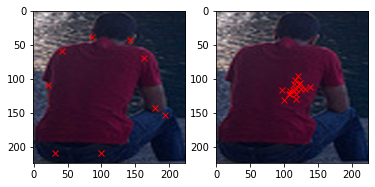

tensor(88.1443, device='cuda:0')

In [34]:
val_dataset = Coco(val_coco_df, 'val', 224, transform=composed_transforms)
batch_size = 32
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

def check_validation_accuracy(model):
    
    with torch.no_grad():
        loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(inputs)
            loss += criterion(outputs, labels)

        print(f"Validiation loss was {loss}")
    
    # visualize some random gt vs prediction
    idx = rn.randint(0, 200)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)
    
    img = img.to(device)
    outputs = model(img.unsqueeze(0))
    outputs = outputs.to('cpu')

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

    return loss 
    

check_validation_accuracy(model)

Training 40 epochs. Dataset is 149813 big. Using batch size 64
2341 minibatches are needed per epoch
Minibatch 1/2341. Loss 0.43448224663734436
Minibatch 51/2341. Loss 0.186533585190773
Minibatch 101/2341. Loss 0.18835057318210602
Minibatch 151/2341. Loss 0.1665700227022171
Minibatch 201/2341. Loss 0.17552337050437927
Minibatch 251/2341. Loss 0.16581958532333374
Minibatch 301/2341. Loss 0.16247829794883728
Minibatch 351/2341. Loss 0.15285727381706238
Minibatch 401/2341. Loss 0.17248453199863434
Minibatch 451/2341. Loss 0.18461140990257263
Minibatch 501/2341. Loss 0.150917187333107
Minibatch 551/2341. Loss 0.17450231313705444
Minibatch 601/2341. Loss 0.14265379309654236
Minibatch 651/2341. Loss 0.15461526811122894
Minibatch 701/2341. Loss 0.16969163715839386
Minibatch 751/2341. Loss 0.15478484332561493
Minibatch 801/2341. Loss 0.153845876455307
Minibatch 851/2341. Loss 0.16014312207698822
Minibatch 901/2341. Loss 0.15049217641353607
Minibatch 951/2341. Loss 0.16944360733032227
Minibatch

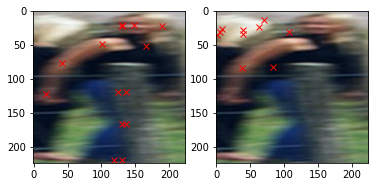

Minibatch 1/2341. Loss 0.13046707212924957
Minibatch 51/2341. Loss 0.13062982261180878
Minibatch 101/2341. Loss 0.1290813833475113
Minibatch 151/2341. Loss 0.12290935218334198
Minibatch 201/2341. Loss 0.15070021152496338
Minibatch 251/2341. Loss 0.13174878060817719
Minibatch 301/2341. Loss 0.13695883750915527
Minibatch 351/2341. Loss 0.13503006100654602
Minibatch 401/2341. Loss 0.1306631714105606
Minibatch 451/2341. Loss 0.14152134954929352
Minibatch 501/2341. Loss 0.13049308955669403
Minibatch 551/2341. Loss 0.14359989762306213
Minibatch 601/2341. Loss 0.13750414550304413
Minibatch 651/2341. Loss 0.1495489776134491
Minibatch 701/2341. Loss 0.15016306936740875
Minibatch 751/2341. Loss 0.12359260022640228
Minibatch 801/2341. Loss 0.14775638282299042
Minibatch 851/2341. Loss 0.14871247112751007
Minibatch 901/2341. Loss 0.13459685444831848
Minibatch 951/2341. Loss 0.12062805145978928
Minibatch 1001/2341. Loss 0.14465542137622833
Minibatch 1051/2341. Loss 0.1345316618680954
Minibatch 1101/

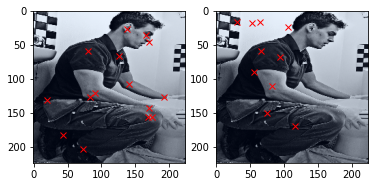

Minibatch 1/2341. Loss 0.1263037919998169
Minibatch 51/2341. Loss 0.11091889441013336
Minibatch 101/2341. Loss 0.1288778930902481
Minibatch 151/2341. Loss 0.13226746022701263
Minibatch 201/2341. Loss 0.13293957710266113
Minibatch 251/2341. Loss 0.1453952193260193
Minibatch 301/2341. Loss 0.12679973244667053
Minibatch 351/2341. Loss 0.13040554523468018
Minibatch 401/2341. Loss 0.13697271049022675
Minibatch 451/2341. Loss 0.14451323449611664
Minibatch 501/2341. Loss 0.11741288006305695
Minibatch 551/2341. Loss 0.13752689957618713
Minibatch 601/2341. Loss 0.1151769608259201
Minibatch 651/2341. Loss 0.12739597260951996
Minibatch 701/2341. Loss 0.13215352594852448
Minibatch 751/2341. Loss 0.13833217322826385
Minibatch 801/2341. Loss 0.11922664940357208
Minibatch 851/2341. Loss 0.12387914955615997
Minibatch 901/2341. Loss 0.1383034586906433
Minibatch 951/2341. Loss 0.1558602899312973
Minibatch 1001/2341. Loss 0.12801946699619293
Minibatch 1051/2341. Loss 0.11901938170194626
Minibatch 1101/23

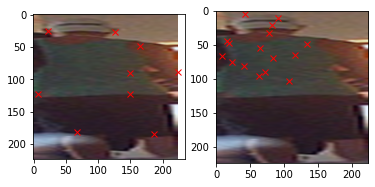

Minibatch 1/2341. Loss 0.11354710906744003
Minibatch 51/2341. Loss 0.12160839885473251
Minibatch 101/2341. Loss 0.11506867408752441
Minibatch 151/2341. Loss 0.11344669759273529
Minibatch 201/2341. Loss 0.12911751866340637
Minibatch 251/2341. Loss 0.11403407156467438
Minibatch 301/2341. Loss 0.12885497510433197
Minibatch 351/2341. Loss 0.12942850589752197
Minibatch 401/2341. Loss 0.11769663542509079
Minibatch 451/2341. Loss 0.1174265518784523
Minibatch 501/2341. Loss 0.11762725561857224
Minibatch 551/2341. Loss 0.11951325833797455
Minibatch 601/2341. Loss 0.12487003207206726
Minibatch 651/2341. Loss 0.11352729052305222
Minibatch 701/2341. Loss 0.1158016100525856
Minibatch 751/2341. Loss 0.12180070579051971
Minibatch 801/2341. Loss 0.1234578937292099
Minibatch 851/2341. Loss 0.11749954521656036
Minibatch 901/2341. Loss 0.12413150817155838
Minibatch 951/2341. Loss 0.1326848417520523
Minibatch 1001/2341. Loss 0.12376902997493744
Minibatch 1051/2341. Loss 0.13090001046657562
Minibatch 1101/

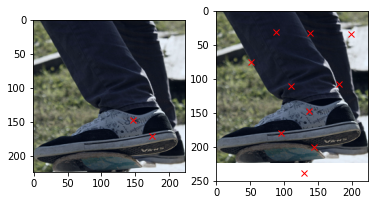

Minibatch 1/2341. Loss 0.13698311150074005
Minibatch 51/2341. Loss 0.10182706266641617
Minibatch 101/2341. Loss 0.11644479632377625
Minibatch 151/2341. Loss 0.10811638832092285
Minibatch 201/2341. Loss 0.12420845031738281
Minibatch 251/2341. Loss 0.10620511323213577
Minibatch 301/2341. Loss 0.1177033856511116
Minibatch 351/2341. Loss 0.11430652439594269
Minibatch 401/2341. Loss 0.12897889316082
Minibatch 451/2341. Loss 0.10724088549613953
Minibatch 501/2341. Loss 0.1037353128194809
Minibatch 551/2341. Loss 0.10925757139921188
Minibatch 601/2341. Loss 0.10469738394021988
Minibatch 651/2341. Loss 0.11082661151885986
Minibatch 701/2341. Loss 0.10936529189348221
Minibatch 751/2341. Loss 0.10915238410234451
Minibatch 801/2341. Loss 0.12848007678985596
Minibatch 851/2341. Loss 0.11482631415128708
Minibatch 901/2341. Loss 0.1034252941608429
Minibatch 951/2341. Loss 0.1076655313372612
Minibatch 1001/2341. Loss 0.14403899013996124
Minibatch 1051/2341. Loss 0.09178934246301651
Minibatch 1101/234

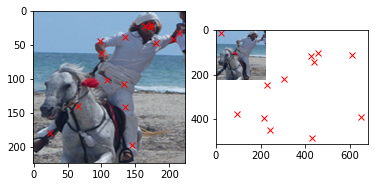

Minibatch 1/2341. Loss 0.11284372210502625
Minibatch 51/2341. Loss 0.1074453592300415
Minibatch 101/2341. Loss 0.12389051169157028
Minibatch 151/2341. Loss 0.10589446872472763
Minibatch 201/2341. Loss 0.12466699630022049
Minibatch 251/2341. Loss 0.11442315578460693
Minibatch 301/2341. Loss 0.11615350842475891
Minibatch 351/2341. Loss 0.10595562309026718
Minibatch 401/2341. Loss 0.10902997106313705
Minibatch 451/2341. Loss 0.10380261391401291
Minibatch 501/2341. Loss 0.09486042708158493
Minibatch 551/2341. Loss 0.10943304747343063
Minibatch 601/2341. Loss 0.09974322468042374
Minibatch 651/2341. Loss 0.10571295768022537
Minibatch 701/2341. Loss 0.10858733206987381
Minibatch 751/2341. Loss 0.11575525254011154
Minibatch 801/2341. Loss 0.09773219376802444
Minibatch 851/2341. Loss 0.10566391795873642
Minibatch 901/2341. Loss 0.11904231458902359
Minibatch 951/2341. Loss 0.12166646122932434
Minibatch 1001/2341. Loss 0.09707439690828323
Minibatch 1051/2341. Loss 0.0984882339835167
Minibatch 110

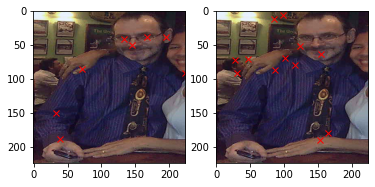

Minibatch 1/2341. Loss 0.10972375422716141
Minibatch 51/2341. Loss 0.11077262461185455
Minibatch 101/2341. Loss 0.10824699699878693
Minibatch 151/2341. Loss 0.10127143561840057
Minibatch 201/2341. Loss 0.09784574806690216
Minibatch 251/2341. Loss 0.08292797207832336
Minibatch 301/2341. Loss 0.09161292761564255
Minibatch 351/2341. Loss 0.0935317799448967
Minibatch 401/2341. Loss 0.1036413311958313
Minibatch 451/2341. Loss 0.11157584190368652
Minibatch 501/2341. Loss 0.13027866184711456
Minibatch 551/2341. Loss 0.12348758429288864
Minibatch 601/2341. Loss 0.08110284805297852
Minibatch 651/2341. Loss 0.10648974031209946
Minibatch 701/2341. Loss 0.11269200593233109
Minibatch 751/2341. Loss 0.10006284713745117
Minibatch 801/2341. Loss 0.10878826677799225
Minibatch 851/2341. Loss 0.08135630935430527
Minibatch 901/2341. Loss 0.09288905560970306
Minibatch 951/2341. Loss 0.11095590144395828
Minibatch 1001/2341. Loss 0.09712599217891693
Minibatch 1051/2341. Loss 0.10381380468606949
Minibatch 110

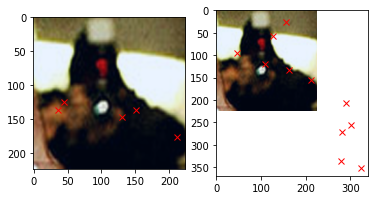

Minibatch 1/2341. Loss 0.09897764772176743
Minibatch 51/2341. Loss 0.09156361222267151
Minibatch 101/2341. Loss 0.1003917008638382
Minibatch 151/2341. Loss 0.11112570017576218
Minibatch 201/2341. Loss 0.09942701458930969
Minibatch 251/2341. Loss 0.1112966239452362
Minibatch 301/2341. Loss 0.09298980981111526
Minibatch 351/2341. Loss 0.09674881398677826
Minibatch 401/2341. Loss 0.1075778678059578
Minibatch 451/2341. Loss 0.0963137075304985
Minibatch 501/2341. Loss 0.10465479642152786
Minibatch 551/2341. Loss 0.10613255947828293
Minibatch 601/2341. Loss 0.09994630515575409
Minibatch 651/2341. Loss 0.08367325365543365
Minibatch 701/2341. Loss 0.1044265553355217
Minibatch 751/2341. Loss 0.1157563328742981
Minibatch 801/2341. Loss 0.09244168549776077
Minibatch 851/2341. Loss 0.1084977462887764
Minibatch 901/2341. Loss 0.10778439044952393
Minibatch 951/2341. Loss 0.09281088411808014
Minibatch 1001/2341. Loss 0.10540518909692764
Minibatch 1051/2341. Loss 0.10041507333517075
Minibatch 1101/234

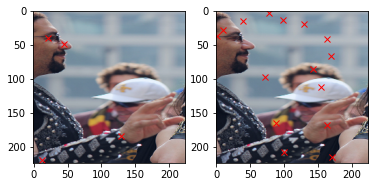

Minibatch 1/2341. Loss 0.0946810394525528
Minibatch 51/2341. Loss 0.09917107969522476
Minibatch 101/2341. Loss 0.10045811533927917
Minibatch 151/2341. Loss 0.09310989081859589
Minibatch 201/2341. Loss 0.11203382909297943
Minibatch 251/2341. Loss 0.09201822429895401
Minibatch 301/2341. Loss 0.0905786007642746
Minibatch 351/2341. Loss 0.0991656631231308
Minibatch 401/2341. Loss 0.09844007343053818
Minibatch 451/2341. Loss 0.09729132056236267
Minibatch 501/2341. Loss 0.09771661460399628
Minibatch 551/2341. Loss 0.0906938835978508
Minibatch 601/2341. Loss 0.10856838524341583
Minibatch 651/2341. Loss 0.09270773828029633
Minibatch 701/2341. Loss 0.09084977954626083
Minibatch 751/2341. Loss 0.10847154259681702
Minibatch 801/2341. Loss 0.1036546602845192
Minibatch 851/2341. Loss 0.1015758365392685
Minibatch 901/2341. Loss 0.09316681325435638
Minibatch 951/2341. Loss 0.14636828005313873
Minibatch 1001/2341. Loss 0.10433049499988556
Minibatch 1051/2341. Loss 0.08167815953493118
Minibatch 1101/23

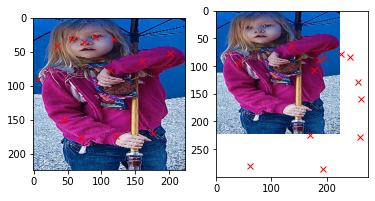

Minibatch 1/2341. Loss 0.0984451100230217
Minibatch 51/2341. Loss 0.10001106560230255
Minibatch 101/2341. Loss 0.10204644501209259
Minibatch 151/2341. Loss 0.08796370774507523
Minibatch 201/2341. Loss 0.1046195700764656
Minibatch 251/2341. Loss 0.10318679362535477
Minibatch 301/2341. Loss 0.09721213579177856
Minibatch 351/2341. Loss 0.08331937342882156
Minibatch 401/2341. Loss 0.10754535347223282
Minibatch 451/2341. Loss 0.09946190565824509
Minibatch 501/2341. Loss 0.09512532502412796
Minibatch 551/2341. Loss 0.10996293276548386
Minibatch 601/2341. Loss 0.10000874102115631
Minibatch 651/2341. Loss 0.1041068509221077
Minibatch 701/2341. Loss 0.11245883256196976
Minibatch 751/2341. Loss 0.09089012444019318
Minibatch 801/2341. Loss 0.09896565973758698
Minibatch 851/2341. Loss 0.09852193295955658
Minibatch 901/2341. Loss 0.10847068578004837
Minibatch 951/2341. Loss 0.10175388306379318
Minibatch 1001/2341. Loss 0.08923791348934174
Minibatch 1051/2341. Loss 0.09205959737300873
Minibatch 1101

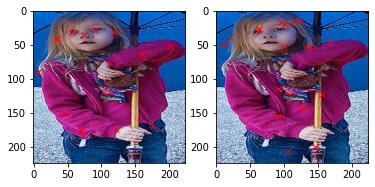

Minibatch 1/2341. Loss 0.09224633127450943
Minibatch 51/2341. Loss 0.09290484338998795
Minibatch 101/2341. Loss 0.09506071358919144
Minibatch 151/2341. Loss 0.09181709587574005
Minibatch 201/2341. Loss 0.08967012166976929
Minibatch 251/2341. Loss 0.11645673960447311
Minibatch 301/2341. Loss 0.09635719656944275
Minibatch 351/2341. Loss 0.0827566608786583
Minibatch 401/2341. Loss 0.11694882810115814
Minibatch 451/2341. Loss 0.08984643965959549
Minibatch 501/2341. Loss 0.0902203693985939
Minibatch 551/2341. Loss 0.0822204202413559
Minibatch 601/2341. Loss 0.09793654829263687
Minibatch 651/2341. Loss 0.10155052691698074
Minibatch 701/2341. Loss 0.09617844969034195
Minibatch 751/2341. Loss 0.10835190117359161
Minibatch 801/2341. Loss 0.08717159926891327
Minibatch 851/2341. Loss 0.08688494563102722
Minibatch 901/2341. Loss 0.08552595227956772
Minibatch 951/2341. Loss 0.09456996619701385
Minibatch 1001/2341. Loss 0.0992734432220459
Minibatch 1051/2341. Loss 0.10681965947151184
Minibatch 1101/

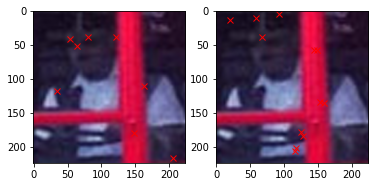

Minibatch 1/2341. Loss 0.07941833138465881
Minibatch 51/2341. Loss 0.08639340847730637
Minibatch 101/2341. Loss 0.0998968854546547
Minibatch 151/2341. Loss 0.08621139079332352
Minibatch 201/2341. Loss 0.10851830989122391
Minibatch 251/2341. Loss 0.10016447305679321
Minibatch 301/2341. Loss 0.08151719719171524
Minibatch 351/2341. Loss 0.08436169475317001
Minibatch 401/2341. Loss 0.09930302947759628
Minibatch 451/2341. Loss 0.0872669667005539
Minibatch 501/2341. Loss 0.1012774109840393
Minibatch 551/2341. Loss 0.09007783979177475
Minibatch 601/2341. Loss 0.09940589964389801
Minibatch 651/2341. Loss 0.10532516986131668
Minibatch 701/2341. Loss 0.08242122828960419
Minibatch 751/2341. Loss 0.08498112112283707
Minibatch 801/2341. Loss 0.08237498253583908
Minibatch 851/2341. Loss 0.10155380517244339
Minibatch 901/2341. Loss 0.0856391191482544
Minibatch 951/2341. Loss 0.16191905736923218
Minibatch 1001/2341. Loss 0.11651220172643661
Minibatch 1051/2341. Loss 0.10523023456335068
Minibatch 1101/

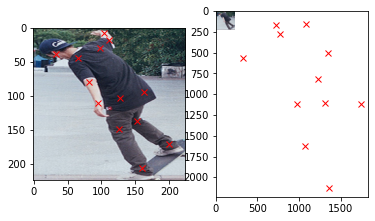

Minibatch 1/2341. Loss 0.09173282235860825
Minibatch 51/2341. Loss 0.1119515523314476
Minibatch 101/2341. Loss 0.0782511904835701
Minibatch 151/2341. Loss 0.0916171744465828
Minibatch 201/2341. Loss 0.08445922285318375
Minibatch 251/2341. Loss 0.08293069154024124
Minibatch 301/2341. Loss 0.0872485339641571
Minibatch 351/2341. Loss 0.08670994639396667
Minibatch 401/2341. Loss 0.08949977904558182
Minibatch 451/2341. Loss 0.08393529802560806
Minibatch 501/2341. Loss 0.0914599820971489
Minibatch 551/2341. Loss 0.08951424062252045
Minibatch 601/2341. Loss 0.10636504739522934
Minibatch 651/2341. Loss 0.09842506796121597
Minibatch 701/2341. Loss 0.08879053592681885
Minibatch 751/2341. Loss 0.1168065220117569
Minibatch 801/2341. Loss 0.0900050699710846
Minibatch 851/2341. Loss 0.10886268317699432
Minibatch 901/2341. Loss 0.09794320911169052
Minibatch 951/2341. Loss 0.09853629767894745
Minibatch 1001/2341. Loss 0.08604110032320023
Minibatch 1051/2341. Loss 0.09979739785194397
Minibatch 1101/234

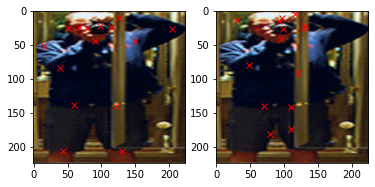

Minibatch 1/2341. Loss 0.09307190775871277
Minibatch 51/2341. Loss 0.0936051532626152
Minibatch 101/2341. Loss 0.08106116950511932
Minibatch 151/2341. Loss 0.10036908835172653
Minibatch 201/2341. Loss 0.09608054161071777
Minibatch 251/2341. Loss 0.09576156735420227
Minibatch 301/2341. Loss 0.0776645839214325
Minibatch 351/2341. Loss 0.08541080355644226
Minibatch 401/2341. Loss 0.088669553399086
Minibatch 451/2341. Loss 0.09075082838535309
Minibatch 501/2341. Loss 0.10539531707763672
Minibatch 551/2341. Loss 0.09837150573730469
Minibatch 601/2341. Loss 0.0921979546546936
Minibatch 651/2341. Loss 0.09590719640254974
Minibatch 701/2341. Loss 0.10773903876543045
Minibatch 751/2341. Loss 0.10382813960313797
Minibatch 801/2341. Loss 0.09598786383867264
Minibatch 851/2341. Loss 0.1085924506187439
Minibatch 901/2341. Loss 0.09260991960763931
Minibatch 951/2341. Loss 0.09647014737129211
Minibatch 1001/2341. Loss 0.10134514421224594
Minibatch 1051/2341. Loss 0.1033724695444107
Minibatch 1101/234

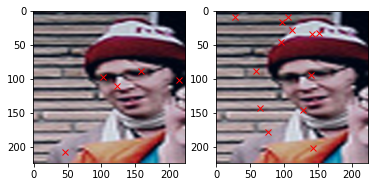

Minibatch 1/2341. Loss 0.09246914088726044
Minibatch 51/2341. Loss 0.1000041738152504
Minibatch 101/2341. Loss 0.09340161830186844
Minibatch 151/2341. Loss 0.09933938831090927
Minibatch 201/2341. Loss 0.10911872982978821
Minibatch 251/2341. Loss 0.08507438004016876
Minibatch 301/2341. Loss 0.09837867319583893
Minibatch 351/2341. Loss 0.09811418503522873
Minibatch 401/2341. Loss 0.09633134305477142
Minibatch 451/2341. Loss 0.07273585349321365
Minibatch 501/2341. Loss 0.07892639189958572
Minibatch 551/2341. Loss 0.1098400130867958
Minibatch 601/2341. Loss 0.07926534116268158
Minibatch 651/2341. Loss 0.08568671345710754
Minibatch 701/2341. Loss 0.09741602838039398
Minibatch 751/2341. Loss 0.09340547770261765
Minibatch 801/2341. Loss 0.10034163296222687
Minibatch 851/2341. Loss 0.09713314473628998
Minibatch 901/2341. Loss 0.09915285557508469
Minibatch 951/2341. Loss 0.09693825244903564
Minibatch 1001/2341. Loss 0.0874195247888565
Minibatch 1051/2341. Loss 0.08421233296394348
Minibatch 1101

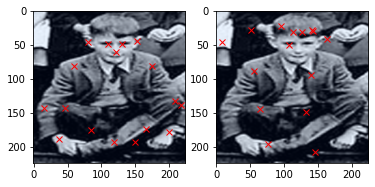

Minibatch 1/2341. Loss 0.08287037163972855
Minibatch 51/2341. Loss 0.0821542888879776
Minibatch 101/2341. Loss 0.08694535493850708
Minibatch 151/2341. Loss 0.09454883635044098
Minibatch 201/2341. Loss 0.08513443917036057
Minibatch 251/2341. Loss 0.08652482181787491
Minibatch 301/2341. Loss 0.08695346117019653
Minibatch 351/2341. Loss 0.0770687684416771
Minibatch 401/2341. Loss 0.08302358537912369
Minibatch 451/2341. Loss 0.09718798100948334
Minibatch 501/2341. Loss 0.08949222415685654
Minibatch 551/2341. Loss 0.08610731363296509
Minibatch 601/2341. Loss 0.08598348498344421
Minibatch 651/2341. Loss 0.07912247627973557
Minibatch 701/2341. Loss 0.07956276088953018
Minibatch 751/2341. Loss 0.0914001613855362
Minibatch 801/2341. Loss 0.10228932648897171
Minibatch 851/2341. Loss 0.10176242887973785
Minibatch 901/2341. Loss 0.09506174176931381
Minibatch 951/2341. Loss 0.09549088776111603
Minibatch 1001/2341. Loss 0.08161596953868866
Minibatch 1051/2341. Loss 0.08876451104879379
Minibatch 1101

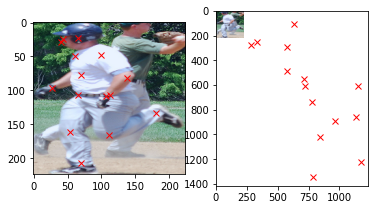

Minibatch 1/2341. Loss 0.08263742923736572
Minibatch 51/2341. Loss 0.10706771165132523
Minibatch 101/2341. Loss 0.09236866235733032
Minibatch 151/2341. Loss 0.08969316631555557
Minibatch 201/2341. Loss 0.08563162386417389
Minibatch 251/2341. Loss 0.08357597887516022
Minibatch 301/2341. Loss 0.09281285852193832
Minibatch 351/2341. Loss 0.10494697093963623
Minibatch 401/2341. Loss 0.09507913142442703
Minibatch 451/2341. Loss 0.09200109541416168
Minibatch 501/2341. Loss 0.09845234453678131
Minibatch 551/2341. Loss 0.10083524137735367
Minibatch 601/2341. Loss 0.0958840548992157
Minibatch 651/2341. Loss 0.10626266896724701
Minibatch 701/2341. Loss 0.0866011306643486
Minibatch 751/2341. Loss 0.09734098613262177
Minibatch 801/2341. Loss 0.08090810477733612
Minibatch 851/2341. Loss 0.10145319253206253
Minibatch 901/2341. Loss 0.09045977890491486
Minibatch 951/2341. Loss 0.09169019013643265
Minibatch 1001/2341. Loss 0.10685444623231888
Minibatch 1051/2341. Loss 0.08979557454586029
Minibatch 110

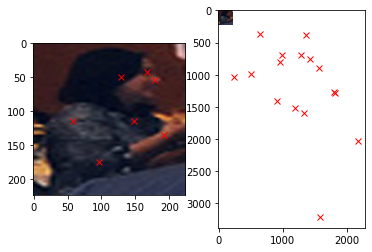

Minibatch 1/2341. Loss 0.09006866067647934
Minibatch 51/2341. Loss 0.08870677649974823
Minibatch 101/2341. Loss 0.08612667769193649
Minibatch 151/2341. Loss 0.08772367984056473
Minibatch 201/2341. Loss 0.08137153834104538
Minibatch 251/2341. Loss 0.09138572961091995
Minibatch 301/2341. Loss 0.08997447043657303
Minibatch 351/2341. Loss 0.07696229964494705
Minibatch 401/2341. Loss 0.07835014909505844
Minibatch 451/2341. Loss 0.07843336462974548
Minibatch 501/2341. Loss 0.08500542491674423
Minibatch 551/2341. Loss 0.09443939477205276
Minibatch 601/2341. Loss 0.09417231380939484
Minibatch 651/2341. Loss 0.09440344572067261
Minibatch 701/2341. Loss 0.09820866584777832
Minibatch 751/2341. Loss 0.07987149804830551
Minibatch 801/2341. Loss 0.0920872688293457
Minibatch 851/2341. Loss 0.10420145094394684
Minibatch 901/2341. Loss 0.08331926167011261
Minibatch 951/2341. Loss 0.0738319382071495
Minibatch 1001/2341. Loss 0.08409044146537781
Minibatch 1051/2341. Loss 0.10351018607616425
Minibatch 110

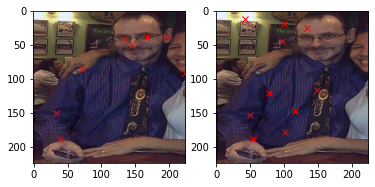

Minibatch 1/2341. Loss 0.09928137809038162
Minibatch 51/2341. Loss 0.08667971193790436
Minibatch 101/2341. Loss 0.09470365196466446
Minibatch 151/2341. Loss 0.09090262651443481
Minibatch 201/2341. Loss 0.08021338284015656
Minibatch 251/2341. Loss 0.09404826164245605
Minibatch 301/2341. Loss 0.06907091289758682
Minibatch 351/2341. Loss 0.08348120003938675
Minibatch 401/2341. Loss 0.08382781594991684
Minibatch 451/2341. Loss 0.08677174150943756
Minibatch 501/2341. Loss 0.09884440898895264
Minibatch 551/2341. Loss 0.08402148634195328
Minibatch 601/2341. Loss 0.0818077102303505
Minibatch 651/2341. Loss 0.08669847995042801
Minibatch 701/2341. Loss 0.08548496663570404
Minibatch 751/2341. Loss 0.09065122902393341
Minibatch 801/2341. Loss 0.05998457223176956
Minibatch 851/2341. Loss 0.08242031186819077
Minibatch 901/2341. Loss 0.08056497573852539
Minibatch 951/2341. Loss 0.1140984520316124
Minibatch 1001/2341. Loss 0.09424252063035965
Minibatch 1051/2341. Loss 0.0870387852191925
Minibatch 1101

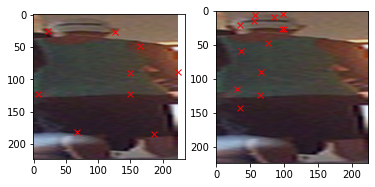

Minibatch 1/2341. Loss 0.0869075208902359
Minibatch 51/2341. Loss 0.07777997106313705
Minibatch 101/2341. Loss 0.09532882273197174
Minibatch 151/2341. Loss 0.09712472558021545
Minibatch 201/2341. Loss 0.10499146580696106
Minibatch 251/2341. Loss 0.07485372573137283
Minibatch 301/2341. Loss 0.09372945129871368
Minibatch 351/2341. Loss 0.08433214575052261
Minibatch 401/2341. Loss 0.08023782819509506
Minibatch 451/2341. Loss 0.10174374282360077
Minibatch 501/2341. Loss 0.09262092411518097
Minibatch 551/2341. Loss 0.08166031539440155
Minibatch 601/2341. Loss 0.07334326207637787
Minibatch 651/2341. Loss 0.07736771553754807
Minibatch 701/2341. Loss 0.09084540605545044
Minibatch 751/2341. Loss 0.09593413025140762
Minibatch 801/2341. Loss 0.10372651368379593
Minibatch 851/2341. Loss 0.09362994134426117


KeyboardInterrupt: 

In [26]:
# TRAINING
train_dataset = Coco(train_coco_df, 'train', 224, transform=composed_transforms)
batch_size = 64
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)

# Define loss and optimizer
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

epochs = 40

print(f"Training {epochs} epochs. Dataset is {len(train_dataset)} big. Using batch size {batch_size}")
print(f"{len(train_dataset)//batch_size+1} minibatches are needed per epoch")

train_loss_history = []
val_loss_history = []

# Train for 2 epochs
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) - 0.5
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
            print(f"Minibatch {i+1}/{len(train_dataset)//batch_size+1}. Loss {loss.item()}")

    # print statistics
    print(f"Epoch {epoch}/2. Loss {running_loss}")
    train_loss_history.append(running_loss)
    val_loss_history.append(check_validation_accuracy(model))

# save model
plt.plot(val_loss_history)
plt.plot(train_loss_history)
torch.save(model.state_dict(), 'model.save')

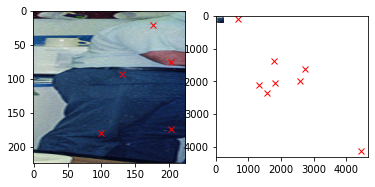

tensor([ -8.1258,  -7.6966,  -1.1502,  -1.2737,   0.3007,  -2.8178,  -6.2262,
          3.0655, -16.6856, -10.0356,  -5.7531,  -1.7282,   4.9751,  -3.9680,
          6.4398,  10.0102,  11.6631,   6.7286,  -2.1547,   2.1698,   7.6152,
          8.6295,  10.9906,   8.3465,   2.5962,  -0.0838,  19.3267,  17.9174,
         -2.2422,  -3.1066,   5.4554,   8.9748,   7.4844,   5.6181],
       grad_fn=<SelectBackward0>)


In [58]:
idx = rn.randint(0, 200)
img, labels = train_dataset[idx]
a = img.numpy()
b = (a - np.min(a))/np.ptp(a)

img = img.to(device)
outputs = model(img.unsqueeze(0))
outputs = outputs.to('cpu')

fig, (ax0, ax1) = plt.subplots(1, 2)
displayImageWithKeyPoints(b, labels, ax0, False)
displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

print(outputs[0])